LGBMをOptunaでチューニング... 
fExp上位(=fImp上位)のFeatureを順に削っていき順次モデル作成  
各modelの比較を行う. 分析の切り口は featureImportance, featureExposure, predictionの相関,sharpe等々 

In [6]:
import seaborn as sns
import csv
import optuna
import optuna.integration.lightgbm as lgb
import itertools, logging, joblib
import networkx as nx
NOTE_NAME = "lgbm2"

In [7]:
ROUND = "238"
TARGET_NAME = f"target"
PREDICTION_NAME = f"prediction"
N_FEATURE = 310

In [8]:
# load models
models = [joblib.load(f"{NOTE_NAME}/best_model_{i}.pkl") for i in range(N_MODEL)]
[len(m.feature_name()) for m in models]

[310, 279, 251, 225, 202, 181, 162, 145]

In [10]:
# Load Dataset
def read_csv(file_path):
    with open(file_path, 'r') as f:
        column_names = next(csv.reader(f))
    dtypes = {x: np.float16 for x in column_names if x.startswith(('feature', 'target'))}
    df = pd.read_csv(file_path, dtype=dtypes, index_col=0)
    return df

train = read_csv(f"../../dataset/numerai_dataset_{ROUND}/numerai_training_data.csv")
tournament = read_csv(f"../../dataset/numerai_dataset_{ROUND}/numerai_tournament_data.csv")
example_preds = \
    pd.read_csv(f"../../dataset/numerai_dataset_{ROUND}/example_predictions.csv")\
    .set_index("id").loc[tournament.index]

# reform
train.sort_index(axis=1, inplace=True)
tournament.sort_index(axis=1, inplace=True)
cols_feature = train.columns[train.columns.str.contains("feature")]
cols_target  = train.columns[train.columns.str.contains("target")]

In [11]:
# generate signals
signals = pd.concat(
    [pd.Series(m.predict(train.loc[:, m.feature_name()]), index=train.index, name=i) for i,m in enumerate(models)], axis=1)
signals = signals.join(train.era).join(train[TARGET_NAME])
signals["eraNum"] = signals.era.str.slice(3).astype(int)

val_signals = pd.concat(
    [pd.Series(m.predict(tournament.loc[:, m.feature_name()]), index=tournament.index, name=i) for i,m in enumerate(models)], axis=1)
val_signals = val_signals.join(tournament.era).join(tournament[TARGET_NAME])
val_signals["eraNum"] = val_signals.era.str.slice(3)

# save
signals.to_csv(f"{NOTE_NAME}/lgbm2_signals_train.csv")
val_signals.to_csv(f"{NOTE_NAME}/lgbm2_signals_val.csv")

In [ ]:
# load
# signals = pd.read_csv(f"{NOTE_NAME}/lgbm2_signals_train.csv", index_col=["id"])
# val_signals = pd.read_csv(f"{NOTE_NAME}/lgbm2_signals_val.csv", index_col=["id"])

-----  
## Importance, Exposure

In [12]:
from scipy.stats import spearmanr
def calcFeatureExposure(X:pd.DataFrame, pred:np.ndarray)->pd.Series:
    # pred: np.array
    exposures = [spearmanr(pred, X[col])[0] for col in X.columns]
    return pd.Series(exposures, index=X.columns)

In [13]:
# featureExpとfeatureImpを各Featureについて計算
feature_info = []  # 各モデルのfe,fiのdataframe
for m in models:
    f = pd.concat(
        [pd.Series(m.feature_importance(), index=m.feature_name()).to_frame(f"fi"),
         calcFeatureExposure(train.loc[:, m.feature_name()], m.predict(train.loc[:, m.feature_name()])).to_frame(f"fe")], 
        axis=1)
    f["feature_category"] = f.index.str.replace("[0-9]","").str.replace("feature_","")
    feature_info.append(f)

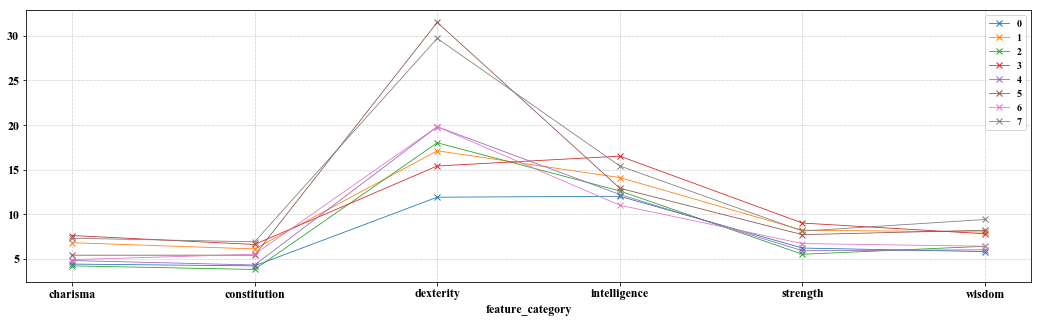

In [17]:
# 各モデルの category別 平均 feature importance 
pd.concat([f.groupby("feature_category").fi.mean().to_frame(i) for i,f in enumerate(feature_info)], axis=1)\
    .round(1).plot(figsize=(18,5), marker="x");

カテゴリ別のfImp傾向は基本的にはあまり変わらない...

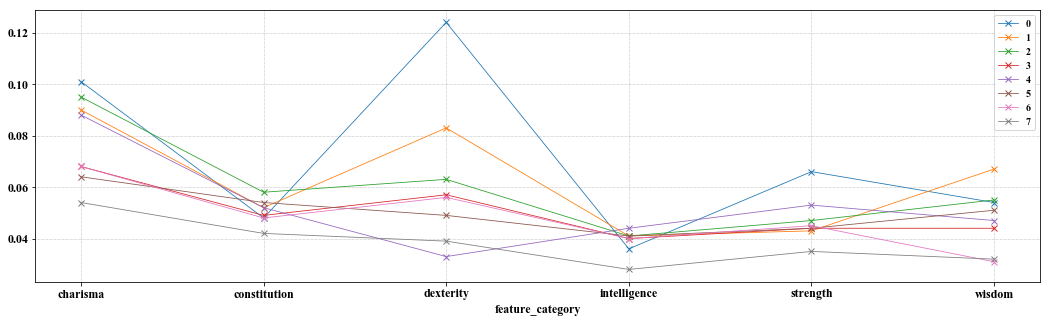

In [18]:
# 各モデルの カテゴリ別 平均 feature exposure
pd.concat([f.fe.abs().groupby(f.feature_category).mean().to_frame(i) for i,f in enumerate(feature_info)], axis=1)\
    .round(3).plot(figsize=(18,5), marker="x")

fExpで見るとカテゴリ別平均はちゃんとばらけている印象  
とはいえカテゴリ間の大小関係は概ね保存されてしまっている...?

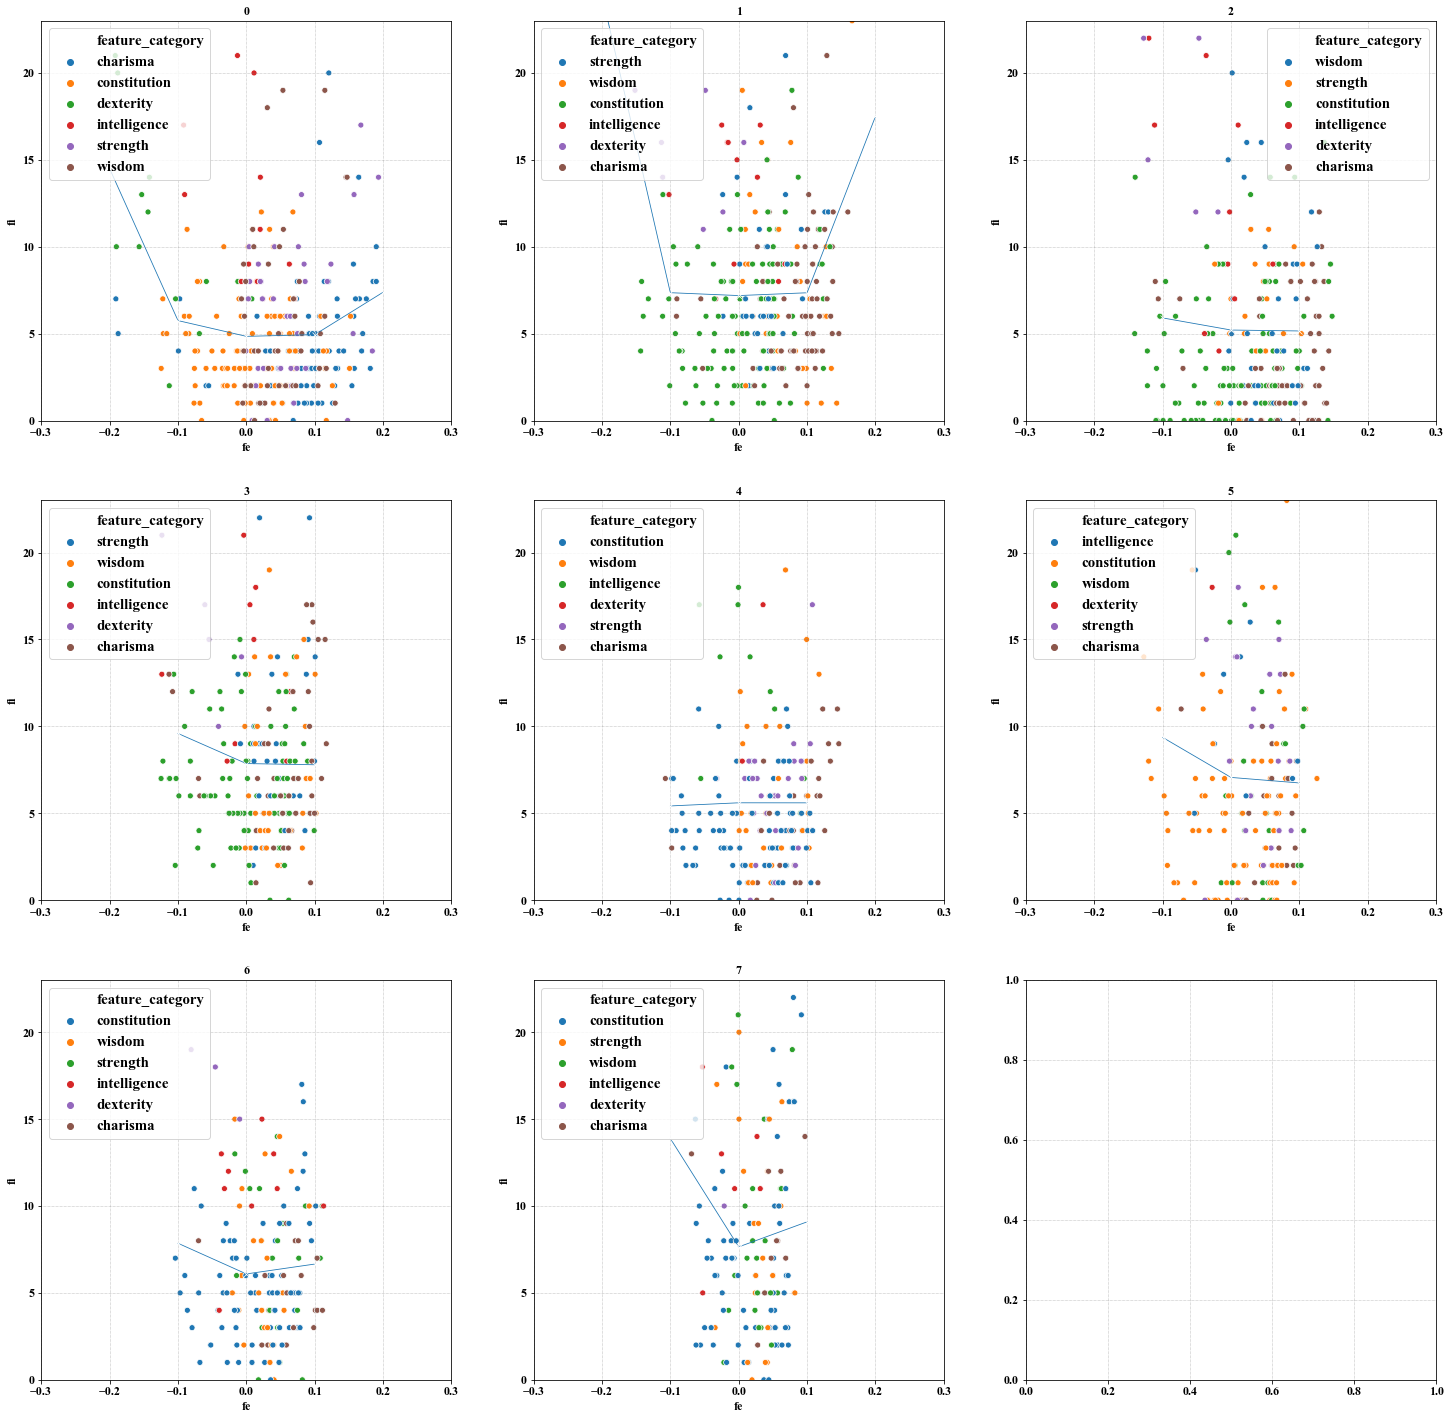

In [25]:
# 各モデル fExp vs. fImp
fig,ax = plt.subplots(3,3, figsize=(25,25)); ax = ax.flatten();
for i,f in enumerate(feature_info):
    sns.scatterplot(x="fe", y="fi", data=f, hue="feature_category", ax=ax[i]);
    sns.lineplot(y="fi", x="fe", data=f[["fi"]].groupby(f.fe.round(1)).fi.mean().reset_index(), marker="x", ax=ax[i])
    ax[i].set_title(i)
    ax[i].legend(fontsize=(15));
    ax[i].set_ylim(0, 23); ax[i].set_xlim(-0.3, +0.3)

model2以降は fExp大 => fImp大 傾向は緩和されているように見える. fExpが高いからといってfImpが高いわけではない.  
分割に使われていなくてもfExpは高くなりうる. 


----  
## outputの比較

---  
signal間 correlation(pearson)

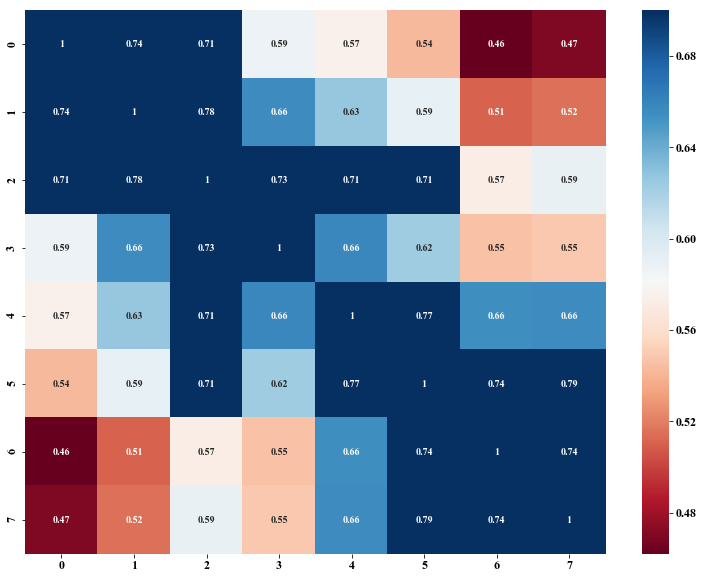

In [26]:
# 相関行列
plt.figure(figsize=(13, 10))
corrMat = signals.iloc[:, :N_MODEL].corr()
sns.heatmap(corrMat, annot=True, cmap="RdBu", vmax=0.7);

model iと model i+1は出力が似ている傾向.

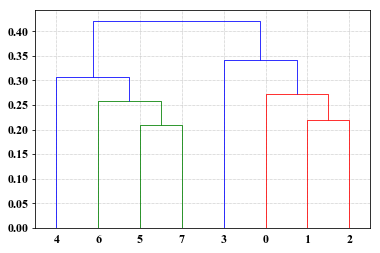

In [27]:
# 相関でデンドログラム
from scipy.cluster.hierarchy import linkage, dendrogram
import scipy.spatial.distance as distance
dArray = distance.squareform(1-corrMat.values)
link = linkage(dArray, method='average')
dendrogram(link);

区分けするとすると, (0,), (1,2), (3,4, 5) といった感じ

---  
model別 CORR score

In [28]:
# Submissions are scored by spearman correlation
def calcRankCorr(i):
    def _main(df):
        ranked_preds = df[i].rank(pct=True, method="first")
        return np.corrcoef(ranked_preds, df[TARGET_NAME])[0, 1]
    return _main

In [29]:
# era毎にcorr計算
corr = pd.concat([signals.groupby("eraNum").apply(calcRankCorr(i)) for i in range(N_MODEL)], axis=1)
val_corr = pd.concat([val_signals.groupby("eraNum").apply(calcRankCorr(i)) for i in range(N_MODEL)], axis=1)

In [30]:
# in sample score
corr.agg(["mean", "std", lambda x: x.mean()/x.std()])

,0,1,2,3,4,5,6,7
mean,0.104368,0.116406,0.071381,0.121857,0.075529,0.064498,0.083028,0.075454
std,0.029311,0.024266,0.024108,0.023458,0.022309,0.020961,0.019623,0.019484
<lambda>,3.560694,4.797006,2.960930,5.194596,3.385577,3.077091,4.231050,3.872548


In [31]:
# validation sample score
val_corr.agg(["mean", "std", lambda x: x.mean()/x.std()])

,0,1,2,3,4,5,6,7
mean,0.019942,0.018115,0.011852,0.011526,0.015107,0.011852,0.010365,0.012591
std,0.025435,0.020427,0.020589,0.017030,0.016816,0.017765,0.019925,0.017961
<lambda>,0.784060,0.886813,0.575652,0.676775,0.898319,0.667133,0.520210,0.700999


validation sharpeは後続モデルの方が優れている

In [32]:
# sample model @ validation
val_signals.join(example_preds).groupby("eraNum").apply(calcRankCorr(PREDICTION_NAME)).agg(["mean", "std", lambda x: x.mean()/x.std()]).to_frame()

,0
mean,0.026577
std,0.027740
<lambda>,0.958093


sampleモデルの方が強いのだが...

---  
Neutralize後のモデル別 CORR score

In [33]:
def neutralize(df, columns, by, proportion=1.0):
    scores = df.loc[:, columns]
    exposures = df[by].values
    exposures = np.hstack(
        (exposures,
         np.asarray(np.mean(scores)) * np.ones(len(exposures)).reshape(-1, 1)))

    scores = scores - proportion * exposures.dot(
        np.linalg.pinv(exposures).dot(scores))
    return scores / scores.std()

def calcRankCorr(i):
    def _main(df):
        ranked_preds = df[i].rank(pct=True, method="first")
        return np.corrcoef(ranked_preds, df[TARGET_NAME])[0, 1]
    return _main

In [34]:
# generate neutralized signals
nSignals = pd.concat([neutralize(train.join(signals[[i]]).dropna(), [i], cols_feature) for i in range(N_MODEL)], axis=1)
nSignals = nSignals.join(train.era).join(train[TARGET_NAME])
nSignals["eraNum"] = nSignals.era.str.slice(3).astype(int)

val_nSignals = pd.concat([neutralize(tournament.join(val_signals[[i]]).dropna(), [i], cols_feature) for i in range(N_MODEL)], axis=1)
val_nSignals = val_nSignals.join(tournament.era).join(tournament[TARGET_NAME])
val_nSignals["eraNum"] = val_nSignals.era.str.slice(3).astype(int)

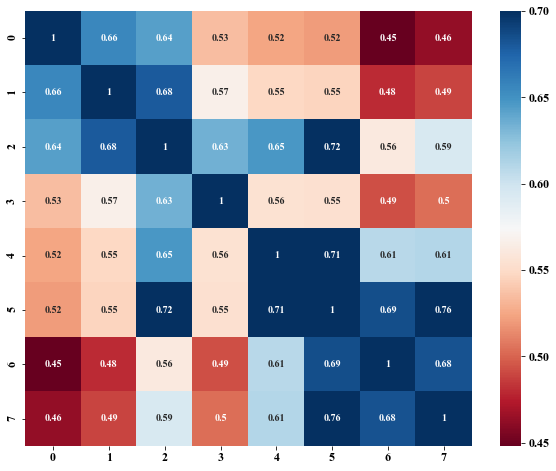

In [35]:
# signal間 相関行列
plt.figure(figsize=(10, 8))
corrMat = nSignals.iloc[:, :N_MODEL].corr()
sns.heatmap(corrMat, annot=True, cmap="RdBu", vmax=0.7);

neutralizeするとmodel間の相関が多少下がる

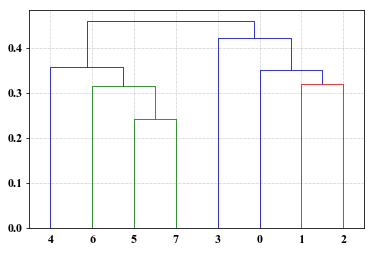

In [36]:
# 相関でデンドログラム
from scipy.cluster.hierarchy import linkage, dendrogram
import scipy.spatial.distance as distance
dArray = distance.squareform(1-nSignals.iloc[:,:N_MODEL].corr().values)
link = linkage(dArray, method='average')
dendrogram(link);

とはいえmodel間の関係はneutralize後も保存される

In [37]:
# era毎にneutralized_corr計算
neutralized_corr = pd.concat([nSignals.groupby("eraNum").apply(calcRankCorr(i)) for i in range(N_MODEL)], axis=1)
val_neutralized_corr = pd.concat([val_nSignals.groupby("eraNum").apply(calcRankCorr(i)) for i in range(N_MODEL)], axis=1)

**Training sample**

In [38]:
neutralized_corr.agg(["mean", "std", lambda x: x.mean()/x.std()])

,0,1,2,3,4,5,6,7
mean,0.102191,0.119536,0.063791,0.123127,0.071314,0.058313,0.080986,0.071617
std,0.020319,0.021885,0.021648,0.021678,0.020522,0.019515,0.019434,0.019551
<lambda>,5.029321,5.461915,2.946798,5.679837,3.474973,2.988100,4.167321,3.663136


In [39]:
neutralized_corr.agg(["mean", "std", lambda x: x.mean()/x.std()]) - corr.agg(["mean", "std", lambda x: x.mean()/x.std()])

,0,1,2,3,4,5,6,7
mean,-0.002177,0.003129,-0.007590,0.001270,-0.004215,-0.006185,-0.002042,-0.003837
std,-0.008992,-0.002381,-0.002460,-0.001780,-0.001787,-0.001446,-0.000190,0.000066
<lambda>,1.468627,0.664909,-0.014132,0.485241,0.089397,-0.088991,-0.063729,-0.209413


**Valiation sample**

In [40]:
val_neutralized_corr.agg(["mean", "std", lambda x: x.mean()/x.std()])  # neutralized

,0,1,2,3,4,5,6,7
mean,0.013099,0.015074,0.010800,0.011249,0.012231,0.010904,0.010155,0.011847
std,0.017971,0.019628,0.016529,0.017266,0.017646,0.017582,0.017819,0.018044
<lambda>,0.728885,0.768001,0.653413,0.651498,0.693134,0.620173,0.569930,0.656588


In [41]:
val_neutralized_corr.agg(["mean", "std", lambda x: x.mean()/x.std()]) - val_corr.agg(["mean", "std", lambda x: x.mean()/x.std()])

,0,1,2,3,4,5,6,7
mean,-0.006843,-0.003041,-0.001052,-0.000277,-0.002876,-0.000948,-0.000210,-0.000743
std,-0.007464,-0.000799,-0.004061,0.000235,0.000830,-0.000183,-0.002106,0.000083
<lambda>,-0.055175,-0.118812,0.077760,-0.025277,-0.205185,-0.046961,0.049720,-0.044411


neutralizeしたところで上がらない

---  
MMC (validationのみ)

In [42]:
val_signals = example_preds.join(val_signals).dropna()

In [43]:
# MMC over validation
def unif(df):
    x = (df.rank(method="first") - 0.5) / len(df)
    return pd.Series(x, index=df.index)

def correlation(predictions, targets):
    ranked_preds = predictions.rank(pct=True, method="first")
    return np.corrcoef(ranked_preds, targets)[0, 1]

def neutralize_series(series, by, proportion=1.0):
    scores = series.values.reshape(-1, 1)
    exposures = by.values.reshape(-1, 1)
    exposures = np.hstack(
        (exposures,
         np.array([np.mean(series)] * len(exposures)).reshape(-1, 1)))
    correction = proportion * (exposures.dot(
        np.linalg.lstsq(exposures, scores, rcond=None)[0]))
    corrected_scores = scores - correction
    neutralized = pd.Series(corrected_scores.ravel(), index=series.index)
    return neutralized

corrs = pd.DataFrame(); mmcs = pd.DataFrame()
for model_id in range(N_MODEL):
    mmc_scores = []
    corr_scores = []
    for _, x in val_signals.groupby("era"):
        series = neutralize_series(pd.Series(unif(x[model_id])), pd.Series(unif(x[PREDICTION_NAME])))
        mmc_scores.append( np.cov(series, x[TARGET_NAME])[0, 1] / (0.29 ** 2) )
        corr_scores.append( correlation(unif(x[model_id]), x[TARGET_NAME]) )
    mmcs.loc[:, model_id] = mmc_scores
    corrs.loc[:, model_id] = corr_scores

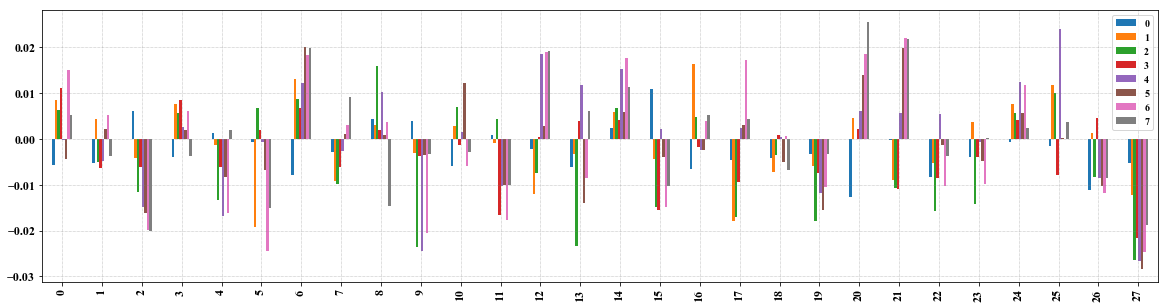

In [44]:
mmcs.plot.bar(figsize=(20, 5));

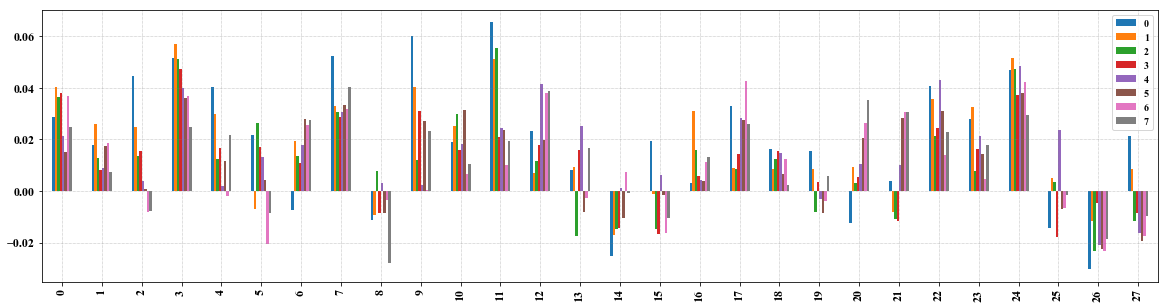

In [48]:
corrs.plot.bar(figsize=(20, 5));

In [45]:
mmcs.agg(["mean", "std", lambda x: x.mean()/x.std()])

,0,1,2,3,4,5,6,7
mean,-0.002609,-0.000852,-0.005004,-0.002933,0.000229,-0.001582,-0.001165,0.000422
std,0.005175,0.008970,0.011830,0.007805,0.012157,0.010699,0.014841,0.011905
<lambda>,-0.504179,-0.094980,-0.423000,-0.375796,0.018863,-0.147848,-0.078508,0.035423


In [46]:
(mmcs+corrs).agg(["mean", "std", lambda x: x.mean()/x.std()])

,0,1,2,3,4,5,6,7
mean,0.017333,0.017263,0.006848,0.008593,0.015336,0.010270,0.009200,0.013012
std,0.027384,0.024748,0.028092,0.021340,0.025667,0.025701,0.033001,0.027839
<lambda>,0.632974,0.697567,0.243777,0.402644,0.597484,0.399596,0.278780,0.467409
